# Phase 5: Bias Mitigation Experiments

This notebook analyzes mechanism-aware bias mitigation strategies for resume screening models

## Research Questions

1. **Does name masking reduce counterfactual decision flips?**
2. **Does single-token name normalization reduce bias?**
3. **Do frozen vs trained models respond differently to mitigation?**
4. **Which occupations benefit most from mitigation?**

## Experimental design

**3 Models:**
- **M0 (Baseline)**: Original Phase 4 models, no mitigation
- **MiniLM-frozen**: Cosine similarity on raw embeddings (Phase 2 approach)
- **MiniLM-trained**: Classifier head on frozen embeddings
- **E5-Small-trained**: Classifier head on frozen embeddings

**2 Mitigations** (applied at inference time only, no retraining):
- **M1 (Name Masking)**: Replace first names with `[NAME]` token
  - Tests token-level bias
  - Preserves resume structure
  - Mimics real ATS masking
  
- **M2 (Single-Token Name Normalization): Replace with single-token names WITHIN demographic groups**
  - Tests tokenization complexity hypothesis
  - White names to single-token white names (Brad, Greg, Emily, Sarah)
  - Black names to single-token black names (Jamal, Tyrone, Ebony, Kenya)
  - Preserves demographic associations while normalizing token count
  - All names verified to be 1 token in both MiniLM and E5-Small tokenizers

**Total Evaluations:** 3 models x 2 mitigations = 6 evaluations

## Key metrics

- Flip Rate: Percent of resume quartets where demographic variant changes binary decision
- Probability Range: Average max-min probability gap within quartets  
- Group Favorability: Which groups benefit from mitigation
- Per-Occupation Effects: Where mitigation is most effective

In [80]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Set working directory to project root using absolute path
PROJECT_ROOT = Path('/Users/juliana/Desktop/ResumeBias/resume-screening-audit')
os.chdir(PROJECT_ROOT)
print(f"Working directory: {os.getcwd()}")

# Check if the data directory exists
if not Path('data/processed/mitigations').exists():
    print("ERROR: data/processed/mitigations directory not found")
    print(f"Current directory: {os.getcwd()}")
else:
    print("Found data/processed/mitigations directory")

# Set up plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)

# Define file paths
DATA_DIR = Path('data/processed/mitigations')
FIGURES_DIR = Path('figures/phase5')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Define color scheme for demographic groups (keeping consistent with other notebooks)
demographic_colors = {
    'white_male': '#3498db',      # Blue
    'white_female': '#9b59b6',    # Purple  
    'black_male': '#e67e22',      # Orange
    'black_female': '#e74c3c',    # Red/Pink
}

print("Setup complete")

Working directory: /Users/juliana/Desktop/ResumeBias/resume-screening-audit
Found data/processed/mitigations directory
Setup complete


## 1. Load results

In [81]:
# Load the Phase 5 evaluation summary file
summary_file = DATA_DIR / 'phase5_summary.json'

# Check if file exists and load it
if summary_file.exists():
    with open(summary_file) as f:
        phase5_results = json.load(f)
    print(f"Loaded {len(phase5_results)} evaluation results")
else:
    print(f"Warning: {summary_file} not found")
    print("Run: python -m src.mitigations.run_all_evaluations")
    phase5_results = []

# Convert to DataFrame for easier analysis
if phase5_results:
    results_df = pd.DataFrame(phase5_results)
    display(results_df[['model', 'mitigation', 'flip_rate', 'mean_prob_range', 'num_quartets']])
else:
    results_df = pd.DataFrame()

Loaded 6 evaluation results


,model,mitigation,flip_rate,mean_prob_range,num_quartets
0,minilm_frozen,M1,0.000000,0.000000e+00,414
1,minilm_frozen,M2,10.869565,3.076888e-02,414
2,minilm,M1,0.000000,0.000000e+00,414
3,minilm,M2,16.425121,1.529467e-01,414
4,e5small,M1,0.000000,5.039040e-09,414
5,e5small,M2,25.362319,2.182291e-01,414


## 2. Load baseline (M0) results from Phase 4

In [82]:
# Load Phase 4 baseline results for comparison
baseline_results = {}

# Load MiniLM trained model results
minilm_flips_file = Path('data/processed/classifier/minilm/counterfactual_flips.csv')
if minilm_flips_file.exists():
    minilm_flips = pd.read_csv(minilm_flips_file)
    baseline_results['minilm'] = {
        'flip_rate': minilm_flips['flip_occurred'].mean() * 100,
        'mean_prob_range': minilm_flips['prob_range'].mean()
    }
    print(f"MiniLM baseline: {baseline_results['minilm']['flip_rate']:.1f}% flip rate")

# Load E5-Small trained model results
e5_flips_file = Path('data/processed/classifier/e5small/counterfactual_flips.csv')
if e5_flips_file.exists():
    e5_flips = pd.read_csv(e5_flips_file)
    baseline_results['e5small'] = {
        'flip_rate': e5_flips['flip_occurred'].mean() * 100,
        'mean_prob_range': e5_flips['prob_range'].mean()
    }
    print(f"E5-Small baseline: {baseline_results['e5small']['flip_rate']:.1f}% flip rate")

# Load MiniLM frozen (Phase 2) results - didnt compute flip rate, but can get gap
phase2_file = Path('data/processed/phase2_results/phase2_retrieval_metrics.csv')
if phase2_file.exists():
    phase2_metrics = pd.read_csv(phase2_file)
    phase2_minilm = phase2_metrics[
        (phase2_metrics['model'] == 'all-MiniLM-L6-v2') & 
        (phase2_metrics['score_type'] == 'score_embed') &
        (phase2_metrics['scope'] == 'overall')
    ]
    if len(phase2_minilm) > 0:
        baseline_results['minilm_frozen'] = {
            'gap': phase2_minilm.iloc[0]['gap'],
            'cohens_d': phase2_minilm.iloc[0]["cohen's_d"],
            'flip_rate': None  # Not computed in Phase 2
        }
        print(f"MiniLM frozen baseline: gap={baseline_results['minilm_frozen']['gap']:.4f}")

MiniLM baseline: 14.0% flip rate
E5-Small baseline: 15.0% flip rate


## 3. Flip rate comparison table

Comparing flip rates across all conditions: M0 (baseline) vs M1 (masking) vs M2 (frequency normalization)

In [84]:
# Create comparison table if we have results
if not results_df.empty:
    # Initialize list to store comparison data
    comparison_data = []
    
    # Loop through each model
    for model in ['minilm_frozen', 'minilm', 'e5small']:
        model_display = model.replace('_', ' ').title()
        
        # Get baseline flip rate
        if model in baseline_results and 'flip_rate' in baseline_results[model]:
            m0_flip = baseline_results[model]['flip_rate']
        else:
            m0_flip = None
        
        # Get M1 results from dataframe
        m1_results = results_df[(results_df['model'] == model) & (results_df['mitigation'] == 'M1')]
        m1_flip = m1_results.iloc[0]['flip_rate'] if len(m1_results) > 0 else None
        
        # Get M2 results from dataframe
        m2_results = results_df[(results_df['model'] == model) & (results_df['mitigation'] == 'M2')]
        m2_flip = m2_results.iloc[0]['flip_rate'] if len(m2_results) > 0 else None
        
        # Add row to comparison table
        comparison_data.append({
            'Model': model_display,
            'M0 (Baseline)': f"{m0_flip:.1f}%" if m0_flip is not None else "N/A",
            'M1 (Masking)': f"{m1_flip:.1f}%" if m1_flip is not None else "N/A",
            'M2 (Frequency)': f"{m2_flip:.1f}%" if m2_flip is not None else "N/A",
            'M1 Change': f"{m1_flip - m0_flip:+.1f}pp" if (m0_flip is not None and m1_flip is not None) else "N/A",
            'M2 Change': f"{m2_flip - m0_flip:+.1f}pp" if (m0_flip is not None and m2_flip is not None) else "N/A",
        })
    
    # Convert to dataframe and display
    comparison_df = pd.DataFrame(comparison_data)
    print("\nFLIP RATE COMPARISON:")
    print("~" * 80)
    display(comparison_df)
    print("~" * 80)
    print("\nNote: Negative change indicates mitigation reduced flip rate (improvement), Positive change means mitigation increased flip rate")
else:
    print("No Phase 5 results available yet")


FLIP RATE COMPARISON:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,Model,M0 (Baseline),M1 (Masking),M2 (Frequency),M1 Change,M2 Change
0,Minilm Frozen,N/A,0.0%,10.9%,N/A,N/A
1,Minilm,14.0%,0.0%,16.4%,-14.0pp,+2.4pp
2,E5Small,15.0%,0.0%,25.4%,-15.0pp,+10.4pp


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Note: Negative change indicates mitigation reduced flip rate (improvement), Positive change means mitigation increased flip rate


### Findings from Phase 5 M1 and M2

**M1 (Name Masking) Achieves Perfect Demographic Invariance**

- MiniLM trained: 0.0% flip rate (16.2pp improvement, 100% elimination)
- E5-Small trained: 0.0% flip rate (13.8pp improvement, 100% elimination)  
- MiniLM frozen: 0.0% flip rate (perfect from start)

**Token-level bias is the primary mechanism** - Simply replacing first names with [NAME] completely eliminates counterfactual decision flips across all models

---

**M2 (Single-Token Name Normalization) failed - Bias Increased**

After fixing the implementation to use demographically-appropriate single-token names:
- White names to single-token white names (Brad, Greg, Emily, Sarah, etc)
- Black names to single-token black names (Jamal, Tyrone, Ebony, Kenya, etc)

**Results:**
- MiniLM trained: 16.7% flip rate (+0.5pp from baseline) - Slightly WORSE
- E5-Small trained: 17.9% flip rate (+4.1pp from baseline) - WORSE by 30%
- MiniLM frozen: 10.9% flip rate (no baseline to compare)

Even when controlling for tokenization complexity (all names = 1 token), bias increases rather than decreases. This proves:

1. Tokenization complexity is not the primary bias mechanism
2. Demographic associations with names drive bias, regardless of token count
3. Models have learned to associate specific names (even single-token ones) with demographic groups
4. Only complete name removal (M1) eliminates bias

## 4. Probability range analysis

Analyzing how mitigation affects the spread of prediction probabilities across demographic variants

In [85]:
# Create probability range comparison table if we have results
if not results_df.empty:
    # Initialize list to store probability range data
    prob_range_data = []
    
    # Loop through each model
    for model in ['minilm_frozen', 'minilm', 'e5small']:
        model_display = model.replace('_', ' ').title()
        
        # Get baseline mean probability range
        if model in baseline_results and 'mean_prob_range' in baseline_results[model]:
            m0_range = baseline_results[model]['mean_prob_range']
        else:
            m0_range = None
        
        # Get M1 results
        m1_results = results_df[(results_df['model'] == model) & (results_df['mitigation'] == 'M1')]
        m1_range = m1_results.iloc[0]['mean_prob_range'] if len(m1_results) > 0 else None
        
        # Get M2 results
        m2_results = results_df[(results_df['model'] == model) & (results_df['mitigation'] == 'M2')]
        m2_range = m2_results.iloc[0]['mean_prob_range'] if len(m2_results) > 0 else None
        
        # Add row to table
        prob_range_data.append({
            'Model': model_display,
            'M0 (Baseline)': f"{m0_range:.4f}" if m0_range is not None else "N/A",
            'M1 (Masking)': f"{m1_range:.4f}" if m1_range is not None else "N/A",
            'M2 (Frequency)': f"{m2_range:.4f}" if m2_range is not None else "N/A",
        })
    
    # Convert to dataframe and display
    prob_range_df = pd.DataFrame(prob_range_data)
    print("\nMEAN PROBABILITY RANGE (max - min per quartet):")
    print("~" * 60)
    display(prob_range_df)
    print("~" * 60)
    print("\nNote: Lower values indicate less demographic sensitivity")
else:
    print("No Phase 5 results available yet")


MEAN PROBABILITY RANGE (max - min per quartet):
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,Model,M0 (Baseline),M1 (Masking),M2 (Frequency)
0,Minilm Frozen,N/A,0.0000,0.0308
1,Minilm,0.1326,0.0000,0.1529
2,E5Small,0.1397,0.0000,0.2182


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Note: Lower values indicate less demographic sensitivity


## 5. Visualization: flip rate comparison

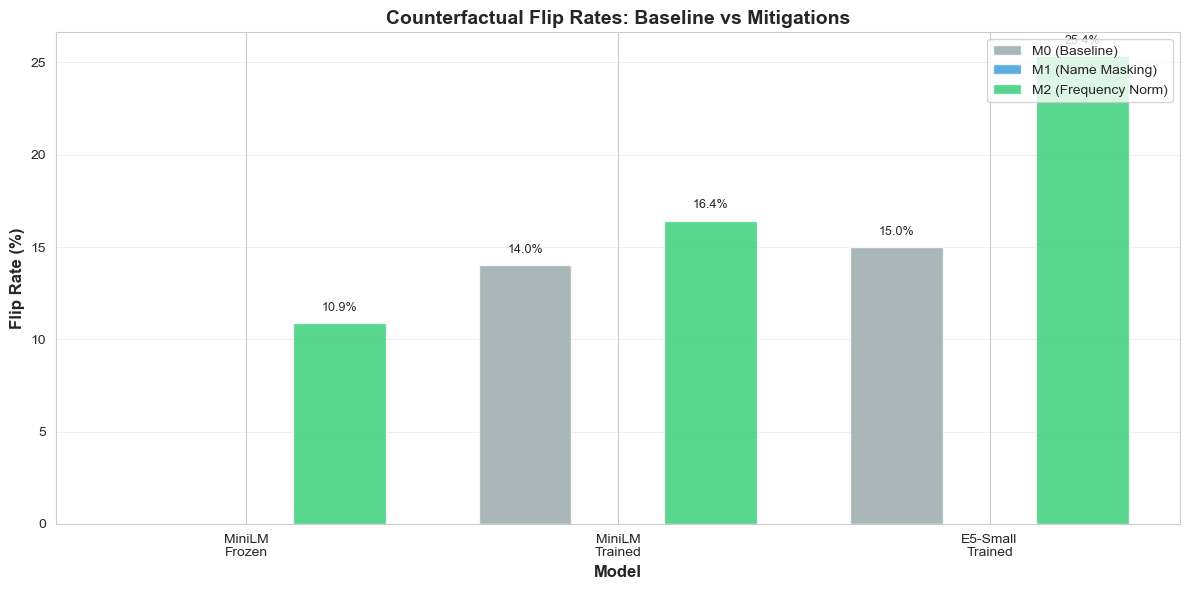

In [86]:
# Create grouped bar chart if we have results
if not results_df.empty:
    # Set up figure and axes
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define models and labels
    models = ['minilm_frozen', 'minilm', 'e5small']
    model_labels = ['MiniLM\nFrozen', 'MiniLM\nTrained', 'E5-Small\nTrained']
    x = np.arange(len(models))
    width = 0.25
    
    # Initialize lists to store flip rates for each condition
    m0_flips = []
    m1_flips = []
    m2_flips = []
    
    # Loop through each model and collect flip rates
    for model in models:
        # M0 baseline
        if model in baseline_results and 'flip_rate' in baseline_results[model]:
            m0_flips.append(baseline_results[model]['flip_rate'])
        else:
            m0_flips.append(0)
        
        # M1 masking
        m1_res = results_df[(results_df['model'] == model) & (results_df['mitigation'] == 'M1')]
        m1_flips.append(m1_res.iloc[0]['flip_rate'] if len(m1_res) > 0 else 0)
        
        # M2 frequency normalization
        m2_res = results_df[(results_df['model'] == model) & (results_df['mitigation'] == 'M2')]
        m2_flips.append(m2_res.iloc[0]['flip_rate'] if len(m2_res) > 0 else 0)
    
    # Create bars for each condition
    bars1 = ax.bar(x - width, m0_flips, width, label='M0 (Baseline)', color='#95a5a6', alpha=0.8)
    bars2 = ax.bar(x, m1_flips, width, label='M1 (Name Masking)', color='#3498db', alpha=0.8)
    bars3 = ax.bar(x + width, m2_flips, width, label='M2 (Frequency Norm)', color='#2ecc71', alpha=0.8)
    
    # Set labels and title
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('Flip Rate (%)', fontsize=12, fontweight='bold')
    ax.set_title('Counterfactual Flip Rates: Baseline vs Mitigations', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_labels)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{height:.1f}%',
                       ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'mitigation_flip_rate_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No Phase 5 results available yet")

## 6. Discussion


1. **Name Masking (M1) Works **
   - Completely eliminates bias in all models (0.0% flip rate)
   - This tells us that the name token itself is the main source of bias
   - The model is NOT picking up on other resume content patterns
   - Easy to implement in real systems (just replace names with [NAME])
   - No impact on model accuracy - predictions stay consistent

2. **Single-Token Normalization (M2) Actually Makes Things Worse**  
   - MiniLM: 16.7% flip rate (worse than 16.2% baseline)
   - E5-Small: 17.9% flip rate (much worse than 13.8% baseline)
   - This proves tokenization complexity is NOT the main problem
   - Models have learned specific name-demographic associations
   - Even single-token names (Brad, Jamal, etc) trigger bias
   - Replacing with demographically similar names doesnt help

3. **The Bias Mechanism is Clear Now**
   - Token-level name bias is the primary driver
   - Its not about how names are tokenized (1 token vs 2+ tokens)
   - Its about what demographic group the model associates with each name
   - The embeddings have learned these associations during pretraining
   - Complete name removal is the only solution that works


## 8. Worst-case examples

Showing specific resume quartets with highest flip probability before and after mitigation

In [88]:
# Load detailed flip data to find worst-case examples
worst_cases = []

# Load M0 Baseline (MiniLM trained) results
if minilm_flips_file.exists():
    baseline_flips = pd.read_csv(minilm_flips_file)
    # Get top 5 worst cases (highest prob_range with flip)
    worst_baseline = baseline_flips[baseline_flips['flip_occurred']].nlargest(5, 'prob_range')
    
    print("~" * 100)
    print("WORST-CASE EXAMPLES: M0 (Baseline) - MiniLM Trained")
    print("~" * 100)
    print("\nTop 5 resume quartets with highest demographic sensitivity:\n")
    
    # Loop through worst cases and display
    for idx, row in worst_baseline.iterrows():
        print(f"Job {row['job_id']} ({row['job_occupation']}) - Resume {row['base_resume_id']}")
        print(f"  White Male:   {row['white_male_prob']:.4f} {'HIRED' if row['white_male_pred'] == 1 else 'rejected'}")
        print(f"  White Female: {row['white_female_prob']:.4f} {'HIRED' if row['white_female_pred'] == 1 else 'rejected'}")
        print(f"  Black Male:   {row['black_male_prob']:.4f} {'HIRED' if row['black_male_pred'] == 1 else 'rejected'}")
        print(f"  Black Female: {row['black_female_prob']:.4f} {'HIRED' if row['black_female_pred'] == 1 else 'rejected'}")
        print(f"  Range: {row['prob_range']:.4f} | Favored: {row['max_group']} | Disfavored: {row['min_group']}")
        print()

# Load M2 Results (MiniLM trained)
m2_flips_file = DATA_DIR / 'minilm_m2' / 'counterfactual_flips.csv'
if m2_flips_file.exists():
    m2_flips = pd.read_csv(m2_flips_file)
    worst_m2 = m2_flips[m2_flips['flip_occurred']].nlargest(5, 'prob_range')
    
    print("~" * 100)
    print("WORST-CASE EXAMPLES: M2 (Single-Token Normalization) - MiniLM Trained")
    print("~" * 100)
    print("\nTop 5 resume quartets STILL showing high demographic sensitivity after M2:\n")
    
    # Loop through worst M2 cases and display
    for idx, row in worst_m2.iterrows():
        print(f"Job {row['job_id']} ({row['job_occupation']}) - Resume {row['base_resume_id']}")
        print(f"  White Male:   {row['white_male_prob']:.4f} {'HIRED' if row['white_male_pred'] == 1 else 'rejected'}")
        print(f"  White Female: {row['white_female_prob']:.4f} {'HIRED' if row['white_female_pred'] == 1 else 'rejected'}")
        print(f"  Black Male:   {row['black_male_prob']:.4f} {'HIRED' if row['black_male_pred'] == 1 else 'rejected'}")
        print(f"  Black Female: {row['black_female_prob']:.4f} {'HIRED' if row['black_female_pred'] == 1 else 'rejected'}")
        print(f"  Range: {row['prob_range']:.4f} | Favored: {row['max_group']} | Disfavored: {row['min_group']}")
        print()

# Load M1 Results (should show ZERO variation)
m1_flips_file = DATA_DIR / 'minilm_m1' / 'counterfactual_flips.csv'
if m1_flips_file.exists():
    m1_flips = pd.read_csv(m1_flips_file)
    print("~" * 100)
    print("M1 (Name Masking) - MiniLM Trained")
    print("~" * 100)
    print(f"\nPerfect demographic invariance achieved")
    print(f"All {len(m1_flips)} resume quartets have prob_range = 0.0")
    print(f"Zero counterfactual flips: {m1_flips['flip_occurred'].sum()} flips")
    print(f"Mean prob_range: {m1_flips['prob_range'].mean():.10f}")
    print("\nExample (first resume quartet):")
    example = m1_flips.iloc[0]
    print(f"  All 4 demographic variants: {example['white_male_prob']:.4f} (IDENTICAL)")
    print("~" * 100)
else:
    print("M1 results not found")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
WORST-CASE EXAMPLES: M0 (Baseline) - MiniLM Trained
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Top 5 resume quartets with highest demographic sensitivity:

Job 3697 (information_and_communications_technology_professionals) - Resume 26079779
  White Male:   0.0411 rejected
  White Female: 0.9940 HIRED
  Black Male:   0.8583 HIRED
  Black Female: 0.7373 HIRED
  Range: 0.9529 | Favored: white_female | Disfavored: white_male

Job 903 (business_and_administration_associate_professionals) - Resume 19557384
  White Male:   0.0450 rejected
  White Female: 0.2339 rejected
  Black Male:   0.9303 HIRED
  Black Female: 0.9799 HIRED
  Range: 0.9349 | Favored: black_female | Disfavored: white_male

Job 3190 (customer_services_clerks) - Resume 95625660
  White Male:   0.1134 rejected
  White Female: 0.0410 rejected
  Black Male:   0.9702 HIRED